# Assignment1 - Bird Species - Classification - Part 2

# Imports

In [1]:
import os
import torch
import numpy as np

import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchsummary import summary
#from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score as auc
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import cv2

import matplotlib.pyplot as plt
import random
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

device = torch.device('cpu')

# Data preparation

In [2]:
# data_dir = '/Users/Public/Documents/'
data_dir = '/workspace/'
train_dir = os.path.join(data_dir,'train')
valid_dir = os.path.join(data_dir,'valid')
test_dir = os.path.join(data_dir,'test')
mf = data_dir + "birds.csv"
df = pd.read_csv(data_dir + "birds.csv")
list_of_class = list(df['labels'].drop_duplicates())
# Create dictionaries
idx_to_class = {k: v for k, v in enumerate(list_of_class)}
class_to_idx = {v: k for k, v in enumerate(list_of_class)}
input_shape = (224, 224, 3)   # (img_width, img_height, n_chanel)

seed = 2020
torch.manual_seed(seed)
if(torch.has_cuda) :
    device = torch.device('cuda')
print(device)

cuda


**Methods**

In [3]:
def show_batch(data_loader):
    # obtain one batch of training images
    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    images = images.numpy() # convert images to numpy for display

    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(15,5))
    for idx in np.arange(10):
        ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
        plt.imshow(np.transpose(images[idx], (1, 2, 0)))
        ax.set_title(idx_to_class[labels[idx].item()])

**Create dictionary & List of path images by type of dataset**

In [5]:
class_dict = {}
classes_1 = os.listdir(train_dir)
#Creating a dictionary of the classes and their corresponding img count
for class_name in classes_1:
    try:
        temp_path = os.path.join(train_dir, class_name)
        class_dict[class_name] = len(os.listdir(temp_path))
    except:
        pass
#creating a dataframe by dictionary
classes_count = pd.DataFrame(class_dict.items(), columns = ['class_name', 'count'])

In [6]:
train_imgs = []
valid_imgs = []
test_imgs = []
# df.head()
for filepath in df.filepaths:
    if 'train' in filepath:
        train_imgs.append(data_dir + filepath)
    elif 'valid' in filepath:
        valid_imgs.append(data_dir + filepath)
    elif 'test' in filepath:
        test_imgs.append(data_dir + filepath)

print(f'Train set size: {len(train_imgs)}\nTest set size: {len(test_imgs)}\nValidation set size: {len(valid_imgs)}\nTotal number of classes: {len(classes_count)}' )

Train set size: 70626
Test set size: 2250
Validation set size: 2250
Total number of classes: 450


# Create data transforms & dataset & Model

In [57]:
# Data augmentation is a good practice for the train set, after we saw in part1 that there is some classes that have small amount of training samples
# we will apply some augmentation:
# crop images to 224x224, randomly flip it horizontally, random rotation of 20+- degrees, normalize and GaussianBlur, for training set

data_transforms_train = transforms.Compose([
        transforms.ToPILImage(),
        transforms.CenterCrop(224),
        transforms.GaussianBlur(kernel_size = (7,9), sigma = (1,1.5)),
        transforms.RandomRotation(20), 
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(contrast = 0.5, saturation = 0.1),
        transforms.ToTensor(),
        # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

data_transforms_other = transforms.Compose([
        transforms.ToPILImage(),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

data_target_transformation = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor()
    ])

**Create Dataset**

In [45]:
class Bird_dataset(Dataset):    
    def __init__(self,path_to_imgs, labels_for_dataset, idx_label, transform, target_transformation=None):
        # path_to_imgs contains paths for images
        # idx_label is dictionary for class to int
        # labels_for_dataset - will say if dataset is train/valid/test
        self.path_to_imgs = path_to_imgs
        self.transform = transform
        self.target_transformation = target_transformation
        self.class_to_int = idx_label
        self.labels = labels_for_dataset
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self,idx):
        path_to_imgs = os.path.join(self.path_to_imgs,self.labels.iloc[idx]) ##
        image = read_image(path_to_imgs)
        label = path_to_imgs.split("/")[-2] # take the label of class
        label = self.class_to_int[label] # convert to int
        
        # # draw between 1 to 3 black box on image (augmantation)
        # if random.random() < 0.7 and self.transform is not data_transforms_other:
        #     for k in range(random.randint(1,3)):
        #         for i in range(random.randint((k+1)*20,(k+1)*35), random.randint((k+1)*35,(k+1)*45)):
        #             for j in range ((k+1)*30,(k+1)*45):
        #                 image[:, j, i] = 0
        #         if random.random() > 0.9:
        #             break

        if self.transform:
            image = self.transform(image)
        # if self.target_transformation:
        #     label = self.target_transformation(label)

        return image, label

*Lets look on augmentation*

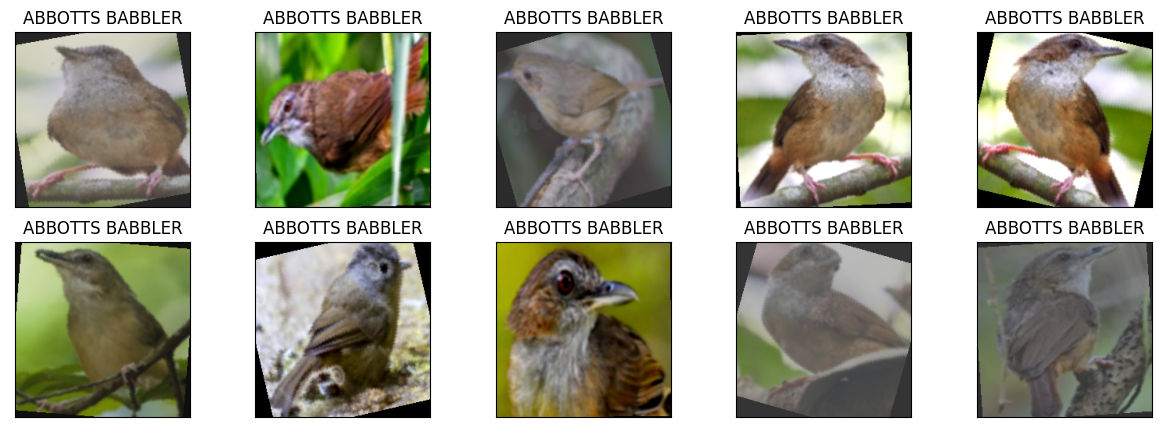

In [46]:
batch_size = 10
path_for_labels = df['filepaths']
dataset_train = Bird_dataset(data_dir, path_for_labels, class_to_idx, data_transforms_train)
temp_list = [k*100 for k in range(10)]
temp_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, sampler = RandomSampler(temp_list), num_workers=0)
show_batch(temp_loader)

**Create Model 1**

In [11]:
class BirdModel(nn.Module):
    def __init__(self):
        super(BirdModel,self).__init__()
        # convolutional layer (3x224x224)
        self.conv1 = nn.Conv2d(3, 6, 3, padding=1) # add last
        # convolutional layer (6x224x224)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=0)
        # convolutional layer (16x222x222)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=0)
        # convolutional layer (32x220x220)
        self.conv4 = nn.Conv2d(32, 64, 5, padding=0)
        # output tensor size is 64x216x216
        # max pooling layer
        self.pool = nn.MaxPool2d(4, 4)
        # output tensor size is 64x54x54
        # linear layer (64 * 54 * 54 -> 1000) (+kernal)
        self.fc1 = nn.Linear(64 * 54 * 54, 1000)
        # linear layer (1000 -> 450)
        self.fc2 = nn.Linear(1000, 450)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x)) # add last
        x = self.pool(x)
        # flatten image input
        x = x.view(-1, 64 * 54 * 54)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = self.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# Mission a. - KFold
**Training & eval**

In [24]:
K = 5 # number of folds for cross validation
skf = StratifiedKFold(n_splits = K, shuffle=True) # make folders by number of samples in class
# skf = KFold(n_splits=5)

x_train = df[df['data set'].isin(['train'])]
y_train = x_train.loc[:,'labels']# Use train data as all the data (train + valid)
path_for_labels = df['filepaths']
only_class = y_train.drop_duplicates()
print_every_n = 200

batch_size = 32
learning_rate = 1e-3
epochs = 10
loss_fn = nn.CrossEntropyLoss()
# from torch.optim.lr_scheduler import StepLR
valid_loss_min = np.Inf # track change in validation loss
history = []
fold_history = []

for fold, (train_idx,val_idx) in enumerate(skf.split(x_train,y_train)):
    print('Fold {}'.format(fold + 1))
    
    # split df to valid & train
    x_train_df = df.iloc[train_idx]
    x_valid_df = df.iloc[val_idx]
    
    # create dataloader by data split
    dataset_train = Bird_dataset(data_dir, path_for_labels, class_to_idx, data_transforms_train)
    dataset_valid = Bird_dataset(data_dir, path_for_labels, class_to_idx, data_transforms_other)

    train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, sampler = RandomSampler(train_idx), num_workers=0)
    valid_loader = DataLoader(dataset=dataset_valid, batch_size=batch_size, sampler = RandomSampler(val_idx), num_workers=0)
    
    model = BirdModel().to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
    # scheduler = StepLR(optimizer, step_size=5, gamma = 0.1) 

    for i in range(epochs):
        print(f'epoch: {i+1} / {epochs}')

        # Training loop
        train_loss = 0.0
        valid_loss = 0.0
        count = 0 
        tp = 0
        size = len(x_train_df)
        num_batches = len(train_loader)
        model.train()
        t=0
        for batch, (images, labels) in enumerate(train_loader):
            # move tensors to GPU if CUDA is available
            images, labels = images.to(device), labels.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(images)
            # calculate the batch loss
            loss = loss_fn(output, labels)
            # update training loss
            train_loss += loss
            # add train acc by add every batch all predicition
            tp += (labels==output.argmax(1)).type(torch.float).sum().item()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()

            count += len(labels)
            if batch % print_every_n == 0:
                current = batch*len(images)
                print(f'train loss = {train_loss:.3f}, after iteration {current}/{size} of samples')
                


        train_loss /= num_batches #total of loss divide by number of batches
        train_acc = tp/size 

        # Validation loop
        model.eval()
        size=len(valid_loader.dataset)
        num_batches = len(valid_loader)
        val_loss=0
        tp=0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(dtype=torch.long)
                labels = labels.to(device)
                pred = model(images)
                val_loss += loss_fn(pred,labels).item()
                tp += (labels==pred.argmax(1)).type(torch.float).sum().item()

            
        val_loss /= num_batches
        val_acc = tp/size
        print(f'accuracy = {val_acc:5f}, valid_loss = {val_loss:2f}')

        print(f'Finish training epoch {i+1} with train loss: {train_loss:4f}')

        # save model if validation loss has decreased
        if val_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            val_loss))
            valid_loss_min = val_loss
            
            model_scripted = torch.jit.script(model) # Export to TorchScript
            model_scripted.save('model_scripted.pt') # Save
            
            torch.save({
                'epoch': i+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': valid_loss_min,
                }, "/workspace/model_scripted.pt")

        history.append({'train_loss':(train_loss.detach().item() if train_loss.requires_grad else train_loss.cpu().numpy()),
                        'val_loss':val_loss, 'train_acc':train_acc, 'val_acc':val_acc})
        print('---------------------------')
        # scheduler.step()
    
    avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc = 0,0,0,0
    for i in range(len(history)):
        avg_train_loss += history[i]['train_loss']
        avg_valid_loss += history[i]['val_loss']
        avg_train_acc += history[i]['train_acc']
        avg_valid_acc += history[i]['val_acc']

    avg_train_loss /= len(history)
    avg_valid_loss /= len(history)
    avg_train_acc /= len(history)
    avg_valid_acc /= len(history)
    
    fold_history.append({'avg_train_loss':avg_train_loss,
                        'avg_val_loss':avg_valid_loss, 'avg_train_acc':avg_train_acc, 'avg_val_acc':avg_valid_acc})

    print('Performance of {} fold cross validation'.format(fold+1))
    print("Average Training Loss: {:.4f} \t Average Valid Loss: {:.4f} \t Average Training Acc: {:.3f} \t Average Valid Acc: {:.3f}".format(avg_train_loss,avg_valid_loss,avg_train_acc,avg_valid_acc))  


Fold 1
epoch: 1 / 10
train loss = 6.114, after iteration 0/56500 of samples
train loss = 1215.239, after iteration 6400/56500 of samples
train loss = 2401.063, after iteration 12800/56500 of samples
train loss = 3583.111, after iteration 19200/56500 of samples
train loss = 4764.510, after iteration 25600/56500 of samples
train loss = 5945.233, after iteration 32000/56500 of samples
train loss = 7124.642, after iteration 38400/56500 of samples
train loss = 8304.194, after iteration 44800/56500 of samples
train loss = 9483.479, after iteration 51200/56500 of samples
accuracy = 0.000000, valid_loss = 5.893880
Finish training epoch 1 with train loss: 5.920903
Validation loss decreased (inf --> 5.893880).  Saving model ...
---------------------------
epoch: 2 / 10
train loss = 5.895, after iteration 0/56500 of samples
train loss = 1183.403, after iteration 6400/56500 of samples
train loss = 2361.662, after iteration 12800/56500 of samples
train loss = 3540.594, after iteration 19200/56500 o

In [30]:
if isinstance(history, torch.Tensor):
    history = history.cpu().numpy()
list_train_loss = [] 
list_valid_loss = []
list_train_acc = []
list_valid_acc = []
for o in history:
    for j in o:
        if j is 'train_loss':
            list_train_loss.append(o.get('train_loss'))
        if j is 'val_loss':
            list_valid_loss.append(o.get('val_loss'))
        if j is 'train_acc':
            list_train_acc.append(o.get('train_acc'))
        if j is 'val_acc':
            list_valid_acc.append(o.get('val_acc'))

In [85]:
def plots_history(train_loss, valid_loss, train_acc, valid_acc):
    fig, ax = plt.subplots(1,2,figsize=(12,4))
    ax[0].plot(train_acc)
    ax[0].plot(valid_acc)
    ax[0].set_title('Model accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('10-Epochs for each Fold')
    ax[0].legend(['Train', 'Valid'], loc='upper left')

    # Plot training & validation loss values
    ax[1].plot(train_loss)
    ax[1].plot(valid_loss)
    ax[1].set_title('Model loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('10-Epochs for each Fold')
    ax[1].legend(['Train', 'Valid'], loc='upper right')
    plt.show()

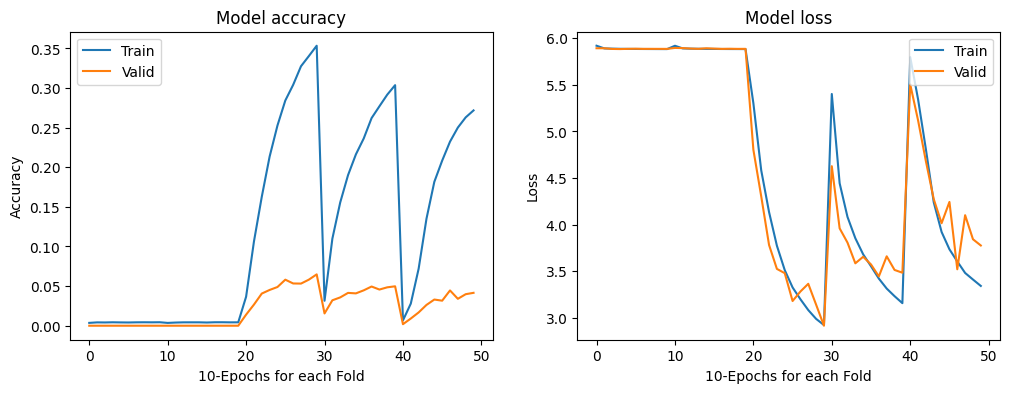

In [86]:
plots_history(list_train_loss, list_valid_loss, list_train_acc, list_valid_acc)

In [36]:
if isinstance(fold_history, torch.Tensor):
    fold_history = fold_history.cpu().numpy()
list_avg_train_loss = [] 
list_avg_valid_loss = []
list_avg_train_acc = []
list_avg_valid_acc = []
for o in fold_history:
    for j in o:
        if j is 'avg_train_loss':
            list_avg_train_loss.append(o.get('avg_train_loss'))
        if j is 'avg_val_loss':
            list_avg_valid_loss.append(o.get('avg_val_loss'))
        if j is 'avg_train_acc':
            list_avg_train_acc.append(o.get('avg_train_acc'))
        if j is 'avg_val_acc':
            list_avg_valid_acc.append(o.get('avg_val_acc'))

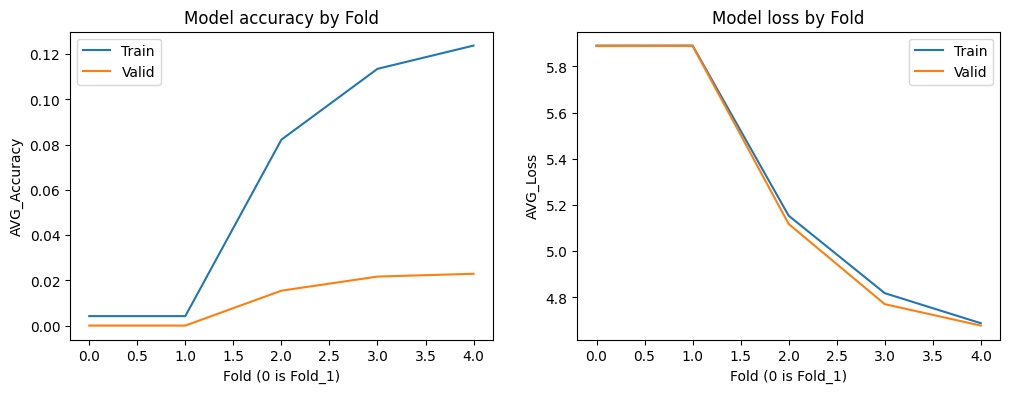

In [42]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(list_avg_train_acc)
ax[0].plot(list_avg_valid_acc)
ax[0].set_title('Model accuracy by Fold')
ax[0].set_ylabel('AVG_Accuracy')
ax[0].set_xlabel('Fold (0 is Fold_1)')
ax[0].legend(['Train', 'Valid'], loc='upper left')

# Plot training & validation loss values
ax[1].plot(list_avg_train_loss)
ax[1].plot(list_avg_valid_loss)
ax[1].set_title('Model loss by Fold')
ax[1].set_ylabel('AVG_Loss')
ax[1].set_xlabel('Fold (0 is Fold_1)')
ax[1].legend(['Train', 'Valid'], loc='upper right')
plt.show()

# Test loss

In [61]:
from torchvision import datasets

# track test loss 
# over 450 birds classes
test_loss = 0.0
class_correct = list(0. for i in range(450))
class_total = list(0. for i in range(450))
total_preds = []
total_gt = []
model.eval() # eval mode

from_imgs = len(train_imgs)
until_imgs = from_imgs + len(test_imgs)
x_test = df[df['data set'].isin(['test'])]
y_test = x_train.loc[:,'labels']# Use train data as all the data (train + valid)
path_for_labels = df['filepaths']

# dataset_test = Bird_dataset(data_dir, path_for_labels, class_to_idx, data_transforms_other)
# test_loader = DataLoader(dataset=dataset_test, batch_size=5, sampler = RandomSampler([i for i in range(from_imgs, until_imgs)]), num_workers=0)

data_transform = transforms.Compose([transforms.CenterCrop(224), 
                                      transforms.ToTensor()])

test_data = datasets.ImageFolder(test_dir, transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=0, shuffle=True)

# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = loss_fn(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    total_preds.append(pred.cpu())
    total_gt.append(target)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    
    for i in range(batch_size):
        try:
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
        except:
            pass

        #Example - turning probabilities back to classes
# >>> a = torch.randn(4, 4)
# >>> a
# tensor([[-1.2360, -0.2942, -0.1222,  0.8475],
#         [ 1.1949, -1.1127, -2.2379, -0.6702],
#         [ 1.5717, -0.9207,  0.1297, -1.8768],
#         [-0.6172,  1.0036, -0.6060, -0.2432]])
# >>> torch.max(a, 1)
# torch.return_types.max(values=tensor([0.8475, 1.1949, 1.5717, 1.0036]), indices=tensor([3, 0, 0, 1]))


# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

acc_dict = {}
for i in range(450):
    if class_total[i] > 0:
        print('Test Accuracy of %5s:%2d%% (%2d/%2d)' % (
            idx_to_class[i],100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
        acc_dict[idx_to_class[i]] = {"class_acc":100 * (class_correct[i] / class_total[i])}
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (idx_to_class[i]))

print('\nTest Accuracy (Overall):%2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 11.661547

Test Accuracy of ABBOTTS BABBLER:20% ( 1/ 5)
Test Accuracy of ABBOTTS BOOBY: 0% ( 0/ 5)
Test Accuracy of ABYSSINIAN GROUND HORNBILL: 0% ( 0/ 5)
Test Accuracy of AFRICAN CROWNED CRANE:20% ( 1/ 5)
Test Accuracy of AFRICAN EMERALD CUCKOO:80% ( 4/ 5)
Test Accuracy of AFRICAN FIREFINCH: 0% ( 0/ 5)
Test Accuracy of AFRICAN OYSTER CATCHER:80% ( 4/ 5)
Test Accuracy of AFRICAN PIED HORNBILL: 0% ( 0/ 5)
Test Accuracy of ALBATROSS:20% ( 1/ 5)
Test Accuracy of ALBERTS TOWHEE: 0% ( 0/ 5)
Test Accuracy of ALEXANDRINE PARAKEET:40% ( 2/ 5)
Test Accuracy of ALPINE CHOUGH: 0% ( 0/ 5)
Test Accuracy of ALTAMIRA YELLOWTHROAT: 0% ( 0/ 5)
Test Accuracy of AMERICAN AVOCET:40% ( 2/ 5)
Test Accuracy of AMERICAN BITTERN:20% ( 1/ 5)
Test Accuracy of AMERICAN COOT: 0% ( 0/ 5)
Test Accuracy of AMERICAN FLAMINGO:60% ( 3/ 5)
Test Accuracy of AMERICAN GOLDFINCH:60% ( 3/ 5)
Test Accuracy of AMERICAN KESTREL:20% ( 1/ 5)
Test Accuracy of AMERICAN PIPIT:20% ( 1/ 5)
Test Accuracy of AMERICAN REDSTART:

In [66]:
acc_df = pd.DataFrame(acc_dict)

print(acc_df.T["class_acc"].sort_values()[:200])

YELLOW HEADED BLACKBIRD     0.0
RED HONEY CREEPER           0.0
CHINESE POND HERON          0.0
RED HEADED WOODPECKER       0.0
CHUCAO TAPACULO             0.0
                           ... 
STORK BILLED KINGFISHER     0.0
RAZORBILL                  20.0
NORTHERN PARULA            20.0
GRAY PARTRIDGE             20.0
GREAT JACAMAR              20.0
Name: class_acc, Length: 200, dtype: float64


# Load the Model

In [74]:
if(torch.has_cuda) :
    device = torch.device('cuda')
checkpoint = torch.load("/workspace/model_scripted.pt", map_location=device)
new_m = BirdModel()
new_m.load_state_dict(checkpoint["model_state_dict"])
new_m.eval()

BirdModel(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=186624, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=450, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (relu): ReLU()
)

# Mission b. : Improvment - on report

# Mission c. : Implementation of required improvements

In [75]:
class Bird_dataset(Dataset):    
    def __init__(self,path_to_imgs, labels_for_dataset, idx_label, transform, target_transformation=None):
        # path_to_imgs contains paths for images
        # idx_label is dictionary for class to int
        # labels_for_dataset - will say if dataset is train/valid/test
        self.path_to_imgs = path_to_imgs
        self.transform = transform
        self.target_transformation = target_transformation
        self.class_to_int = idx_label
        self.labels = labels_for_dataset
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self,idx):
        path_to_imgs = os.path.join(self.path_to_imgs,self.labels.iloc[idx]) ##
        image = read_image(path_to_imgs)
        label = path_to_imgs.split("/")[-2] # take the label of class
        label = self.class_to_int[label] # convert to int
        
        # draw between 1 to 3 black box on image (augmantation)
        if random.random() < 0.7 and self.transform is not data_transforms_other:
            for k in range(random.randint(1,3)):
                for i in range(random.randint((k+1)*20,(k+1)*35), random.randint((k+1)*35,(k+1)*45)):
                    for j in range ((k+1)*30,(k+1)*45):
                        image[:, j, i] = 0
                if random.random() > 0.9:
                    break

        if self.transform:
            image = self.transform(image)
        # if self.target_transformation:
        #     label = self.target_transformation(label)

        return image, label

In [82]:
list_sampler = []
for i in range(len(train_imgs)):
    list_sampler.append(i)
    
other_list_sampler = []
from_imgs = len(train_imgs) + len(test_imgs)+1
until_imgs = from_imgs + len(valid_imgs)
for i in range(from_imgs,until_imgs):
    other_list_sampler.append(i)

In [84]:
print_every_n = 200
batch_size = 32
learning_rate = 1e-3
epochs = 5
loss_fn = nn.CrossEntropyLoss()
# from torch.optim.lr_scheduler import StepLR
valid_loss_min = np.Inf # track change in validation loss
new_history = []


# create dataloader
new_dataset_train = Bird_dataset(data_dir, path_for_labels, class_to_idx, data_transforms_train)
new_dataset_valid = Bird_dataset(data_dir, path_for_labels, class_to_idx, data_transforms_other)

train_loader = DataLoader(dataset=new_dataset_train, batch_size=batch_size, sampler = RandomSampler(list_sampler), num_workers=0)
valid_loader = DataLoader(dataset=new_dataset_valid, batch_size=batch_size, sampler = RandomSampler(other_list_sampler), num_workers=0)
    
new_m.to(device)
optimizer = torch.optim.Adam(new_m.parameters(),lr=learning_rate)
# scheduler = StepLR(optimizer, step_size=5, gamma = 0.1) 

for i in range(epochs):
    print(f'epoch: {i+1} / {epochs}')

    # Training loop
    train_loss = 0.0
    valid_loss = 0.0
    count = 0 
    tp = 0
    size = len(list_sampler)
    num_batches = len(train_loader)
    new_m.train()
    t=0
    for batch, (images, labels) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        images, labels = images.to(device), labels.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = new_m(images)
        # calculate the batch loss
        loss = loss_fn(output, labels)
        # update training loss
        train_loss += loss
        # add train acc by add every batch all predicition
        tp += (labels==output.argmax(1)).type(torch.float).sum().item()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()

        count += len(labels)
        if batch % print_every_n == 0:
            current = batch*len(images)
            print(f'train loss = {train_loss:.3f}, after iteration {current}/{size} of samples')
                


    train_loss /= num_batches #total of loss divide by number of batches
    train_acc = tp/size 

    # Validation loop
    new_m.eval()
    size=len(valid_loader.dataset)
    num_batches = len(valid_loader)
    val_loss=0
    tp=0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(dtype=torch.long)
            labels = labels.to(device)
            pred = new_m(images)
            val_loss += loss_fn(pred,labels).item()
            tp += (labels==pred.argmax(1)).type(torch.float).sum().item()

            
    val_loss /= num_batches
    val_acc = tp/size
    print(f'accuracy = {val_acc:5f}, valid_loss = {val_loss:2f}')

    print(f'Finish training epoch {i+1} with train loss: {train_loss:4f}')

    # save model if validation loss has decreased
    if val_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        val_loss))
        valid_loss_min = val_loss
            
        model_scripted_2 = torch.jit.script(new_m) # Export to TorchScript
        model_scripted_2.save('model_scripted_2.pt') # Save
            
        torch.save({
            'epoch': i+1,
            'model_state_dict': new_m.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': valid_loss_min,
            }, "/workspace/model_scripted_2.pt")

    new_history.append({'train_loss':(train_loss.detach().item() if train_loss.requires_grad else train_loss.cpu().numpy()),
                        'val_loss':val_loss, 'train_acc':train_acc, 'val_acc':val_acc})
    print('---------------------------')
    # scheduler.step()


epoch: 1 / 5
train loss = 4.205, after iteration 0/70626 of samples
train loss = 870.533, after iteration 6400/70626 of samples
train loss = 1675.779, after iteration 12800/70626 of samples
train loss = 2470.677, after iteration 19200/70626 of samples
train loss = 3242.518, after iteration 25600/70626 of samples
train loss = 4009.139, after iteration 32000/70626 of samples
train loss = 4756.669, after iteration 38400/70626 of samples
train loss = 5506.856, after iteration 44800/70626 of samples
train loss = 6229.816, after iteration 51200/70626 of samples
train loss = 6968.176, after iteration 57600/70626 of samples
train loss = 7681.142, after iteration 64000/70626 of samples
train loss = 8400.041, after iteration 70400/70626 of samples
accuracy = 0.005218, valid_loss = 3.937021
Finish training epoch 1 with train loss: 3.814840
Validation loss decreased (inf --> 3.937021).  Saving model ...
---------------------------
epoch: 2 / 5
train loss = 3.863, after iteration 0/70626 of samples

In [95]:
# track test loss 
# over 450 birds classes
test_loss = 0.0
class_correct = list(0. for i in range(450))
class_total = list(0. for i in range(450))
total_preds = []
total_gt = []

new_m.eval() # eval mode

test_data_2 = datasets.ImageFolder(test_dir, transform=data_transform)
test_loader1 = torch.utils.data.DataLoader(test_data_2, batch_size=batch_size, 
                                          num_workers=0, shuffle=True)

# iterate over test data
for data, target in test_loader1:
    # move tensors to GPU if CUDA is available
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = new_m(data)
    # calculate the batch loss
    loss = loss_fn(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    total_preds.append(pred.cpu())
    total_gt.append(target)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    
    for i in range(batch_size):
        try:
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
        except:
            pass

        #Example - turning probabilities back to classes
# >>> a = torch.randn(4, 4)
# >>> a
# tensor([[-1.2360, -0.2942, -0.1222,  0.8475],
#         [ 1.1949, -1.1127, -2.2379, -0.6702],
#         [ 1.5717, -0.9207,  0.1297, -1.8768],
#         [-0.6172,  1.0036, -0.6060, -0.2432]])
# >>> torch.max(a, 1)
# torch.return_types.max(values=tensor([0.8475, 1.1949, 1.5717, 1.0036]), indices=tensor([3, 0, 0, 1]))


# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

acc_dict_1 = {}
for i in range(450):
    if class_total[i] > 0:
        print('Test Accuracy of %5s:%2d%% (%2d/%2d)' % (
            idx_to_class[i],100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
        acc_dict_1[idx_to_class[i]] = {"class_acc":100 * (class_correct[i] / class_total[i])}
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (idx_to_class[i]))

print('\nTest Accuracy (Overall):%2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 2.845515

Test Accuracy of ABBOTTS BABBLER: 0% ( 0/ 5)
Test Accuracy of ABBOTTS BOOBY: 0% ( 0/ 5)
Test Accuracy of ABYSSINIAN GROUND HORNBILL: 0% ( 0/ 5)
Test Accuracy of AFRICAN CROWNED CRANE:60% ( 3/ 5)
Test Accuracy of AFRICAN EMERALD CUCKOO:80% ( 4/ 5)
Test Accuracy of AFRICAN FIREFINCH:40% ( 2/ 5)
Test Accuracy of AFRICAN OYSTER CATCHER:60% ( 3/ 5)
Test Accuracy of AFRICAN PIED HORNBILL:20% ( 1/ 5)
Test Accuracy of ALBATROSS: 0% ( 0/ 5)
Test Accuracy of ALBERTS TOWHEE:20% ( 1/ 5)
Test Accuracy of ALEXANDRINE PARAKEET:40% ( 2/ 5)
Test Accuracy of ALPINE CHOUGH: 0% ( 0/ 5)
Test Accuracy of ALTAMIRA YELLOWTHROAT: 0% ( 0/ 5)
Test Accuracy of AMERICAN AVOCET:20% ( 1/ 5)
Test Accuracy of AMERICAN BITTERN:20% ( 1/ 5)
Test Accuracy of AMERICAN COOT:20% ( 1/ 5)
Test Accuracy of AMERICAN FLAMINGO:40% ( 2/ 5)
Test Accuracy of AMERICAN GOLDFINCH:40% ( 2/ 5)
Test Accuracy of AMERICAN KESTREL: 0% ( 0/ 5)
Test Accuracy of AMERICAN PIPIT: 0% ( 0/ 5)
Test Accuracy of AMERICAN REDSTART:2

In [91]:
acc_df_1 = pd.DataFrame(acc_dict_1)

print(acc_df_1.T["class_acc"].sort_values()[:120])

ABBOTTS BABBLER              0.0
STRIPED OWL                  0.0
GREY CUCKOOSHRIKE            0.0
BUFFLEHEAD                   0.0
STORK BILLED KINGFISHER      0.0
                            ... 
RED FACED CORMORANT         20.0
DOUBLE BRESTED CORMARANT    20.0
FASCIATED WREN              20.0
DOWNY WOODPECKER            20.0
PHILIPPINE EAGLE            20.0
Name: class_acc, Length: 120, dtype: float64


# Mission d. : Inference-Time-Augmentation

In [92]:
import scipy as sp

# Each function takes a dataset (multiple images) together with an augmentation parameter, and returns a new altered dataset of the same shape
def flip_lr(images):
    return np.flip(images, axis=2)

def shift(images, shift, axis):
    return np.roll(images, shift, axis=axis)

def rotate(images, angle):
    return sp.ndimage.rotate(
        images, angle, axes=(1,2),
        reshape=False, mode='nearest')

# Aggregation function that takes a set of predictions, averages them, and calculates the final accuracy
def agg_acc(predictions, y):
    y_classes = np.argmax(y, axis=1)
    pred_agg = np.mean(predictions, axis=0)
    preds = np.argmax(pred_agg, axis=1)
    acc = np.mean(preds == y_classes)
    return acc

In [93]:
pred = new_m.predict(x_test)

pred_f = new_m.predict(flip_lr(x_test))

pred_w0 = new_m.predict(shift(x_test, -3, axis=2))
pred_w1 = new_m.predict(shift(x_test, 3, axis=2))

pred_h0 = new_m.predict(shift(x_test, -3, axis=1))
pred_h1 = new_m.predict(shift(x_test, 3, axis=1))

pred_r0 = new_m.predict(rotate(x_test, -20))
pred_r1 = new_m.predict(rotate(x_test, 20))

AttributeError: 'BirdModel' object has no attribute 'predict'

In [ ]:
preds_f = np.stack((pred, pred_f))
acc_f = agg_acc(preds_f, y_test)

preds_w = np.stack((pred, pred_w0, pred_w1))
acc_w = agg_acc(preds_w, y_test)

preds_h = np.stack((pred, pred_h0, pred_h1))
acc_h = agg_acc(preds_h, y_test)

preds_hw = np.stack((pred, pred_h0, pred_h1, pred_w0, pred_w1))
acc_hw = agg_acc(preds_hw, y_test)

preds_fhw = np.stack((pred, pred_h0, pred_h1, pred_w0, pred_w1, pred_f))
acc_fhw = agg_acc(preds_fhw, y_test)

preds_r = np.stack((pred, pred_r0, pred_r1))
acc_r = agg_acc(preds_r, y_test)

preds_fhwr = np.stack((pred, pred_h0, pred_h1, pred_w0, pred_w1, pred_f, pred_r0, pred_r1))
acc_fhwr = agg_acc(preds_fhwr, y_test)

# Mission e. : Add few images of a new category
For that mission we need to change the last layer from 450 final output to 451
we will ceate new_model base on the base_model that we build.
Then add the layers of the base_model to the new_model - except 2 final layers.
Now make the layers of the new_model non-trainable as we don't want our model to be trained again.
Now we will add a dense layer at the end and we will only train this dense layer.
Now we will train the model with output for all the 451 classes.

In [15]:
print(('m' if 'motacilla' in list_of_class else 's'))

s


In [ ]:
list_of_class.append('Motacilla')

new_model = BirdModel()

# getting all the layers except the last two layers
for layer in model.layers[:-2]: #just exclude the last two layers from base_model
    new_model.add(layer)

for layer in new_model.layers:
    layer.trainable = False

weights_training = model.layers[-2].get_weights()
new_model.layers[-2].set_weights(weights_training) 

new_model.add(nn.Linear(list_of_class, name = 'fc3')

In [ ]:
acc_df = pd.DataFrame(acc_dict)

print(acc_df.T["class_acc"].sort_values()[:10])

# Loading the model to make inference

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
# for i in range(450):
#     precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
#     average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# # A "micro-average": quantifying score on all classes jointly
# precision["micro"], recall["micro"], _ = precision_recall_curve(
#     Y_test.ravel(), y_score.ravel()
# )
# average_precision["micro"] = average_precision_score(Y_test, y_score, average="micro")

